# TESS Mission model training

## Dependencies

In [1]:
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import requests
import joblib
import random as rand
from sklearn.preprocessing import StandardScaler

2025-10-05 14:54:47.360089: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Consuming the latest available TESS exoplanets database

In [2]:
print("Downloading TESS mission data...")
url = 'https://exoplanetarchive.ipac.caltech.edu/cgi-bin/IceTable/nph-iceTblDownload'
tess_payload = {
    "workspace": "2025.10.01_20.06.09_019818/TblView/2025.10.04_08.07.24_035625",
    "useTimestamp": 1,
    "table": "/exodata/kvmexoweb/ExoTables/TOI.tbl",
    "format": "CSV",
    "user": "",
    "label": "",
    "columns": "all",
    "rows": "all",
    "mission": "ExoplanetArchive"
}
response = requests.post(url, data=tess_payload)
filename = "tess_db.csv"
with open(filename, "wb") as f:
    f.write(response.content)
print("TESS mission data downloaded!")

TESS mission data downloaded!


## Definition of the neural network architecture

In [3]:
def build_mlp(column_count):
    inputs = keras.Input(shape=(column_count,))
    
    x = keras.layers.Dense(32)(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.3)(x)

    x = keras.layers.Dense(16)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Dense(8)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs, output)

## Data preprocessing

In [4]:

df = pd.read_csv(filename, comment='#')
cols_to_drop = [
    "rowid", "toi", "toipfx", "tid", "ctoi_alias", "pl_pnum",
    "rastr", "raerr1", "raerr2", "decstr", "dec", "decerr1", "decerr2",
    "st_pmralim", "st_pmrasymerr",
    "st_pmdeclim", "st_pmdecsymerr",
    "pl_tranmidlim", "pl_tranmidsymerr",
    "pl_orbperlim", "pl_orbpersymerr",
    "pl_trandurhlim", "pl_trandurhsymerr",
    "pl_trandeplim", "pl_trandepsymerr",
    "pl_radelim", "pl_radesymerr",
    "pl_insolerr1", "pl_insolerr2", "pl_insollim", "pl_insolsymerr",
    "pl_eqterr1", "pl_eqterr2", "pl_eqtlim", "pl_eqtsymerr",
    "st_tmaglim", "st_tmagsymerr",
    "st_distlim", "st_distsymerr",
    "st_tefflim", "st_teffsymerr",
    "st_logglim", "st_loggsymerr",
    "st_radlim", "st_radsymerr",
    "toi_created", "rowupdate"
]

df = df.drop(columns=cols_to_drop).reset_index(drop=True)

Y = df['tfopwg_disp'].map({'FP': 0, 'FA': 0, 'CP': 1, 'KP': 1})
X = df.drop(columns=['tfopwg_disp'])
X_filled = X.fillna(0)
X_encoded = pd.get_dummies(X_filled, drop_first=False).astype(np.float32)

mask = Y.notna()
X_encoded = X_encoded[mask]
Y = Y[mask].astype(np.float32)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded).astype(np.float32)
joblib.dump(scaler, 'tess_scaler.pkl')


['tess_scaler.pkl']

## Train/test split

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42, shuffle=True
)

## Neural network compilation

In [6]:
model = build_mlp(X_encoded.shape[1])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy'
)
model.summary()

I0000 00:00:1759694097.030978  254384 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6631 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 39)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,177 (8.50 KB)

 Trainable params: 2,065 (8.07 KB)

 Non-trainable params: 112 (448.00 B)

## Training callbacks

In [7]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

## Model fitting

In [8]:
model.fit(
    X_train, Y_train,
    batch_size=64,
    epochs=1000,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/1000


2025-10-05 14:54:59.483020: I external/local_xla/xla/service/service.cc:163] XLA service 0x748434003fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-05 14:54:59.483041: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2025-10-05 14:54:59.526228: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-05 14:54:59.853739: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301


 1/29 ━━━━━━━━━━━━━━━━━━━━ 1:48 4s/step - loss: 0.7604

I0000 00:00:1759694101.774272  279943 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.7454 - val_loss: 0.6672
Epoch 2/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6782 - val_loss: 0.6345
Epoch 3/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6433 - val_loss: 0.5985
Epoch 4/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6286 - val_loss: 0.5738
Epoch 5/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6104 - val_loss: 0.5494
Epoch 6/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5958 - val_loss: 0.5263
Epoch 7/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5777 - val_loss: 0.5095
Epoch 8/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5616 - val_loss: 0.4894
Epoch 9/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5466 - val_loss: 0.4716
Epoch 10/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5406 - val_loss: 0.4592
Epoch 11/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5284 - val_loss: 0.4485
Epoch 12/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

In [9]:
model.save('tess.keras')

## Testing and model evaluation

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
                precision    recall  f1-score   support

FALSE POSITIVE       0.86      0.89      0.87       245
     CONFIRMED       0.90      0.87      0.88       268

      accuracy                           0.88       513
     macro avg       0.88      0.88      0.88       513
  weighted avg       0.88      0.88      0.88       513



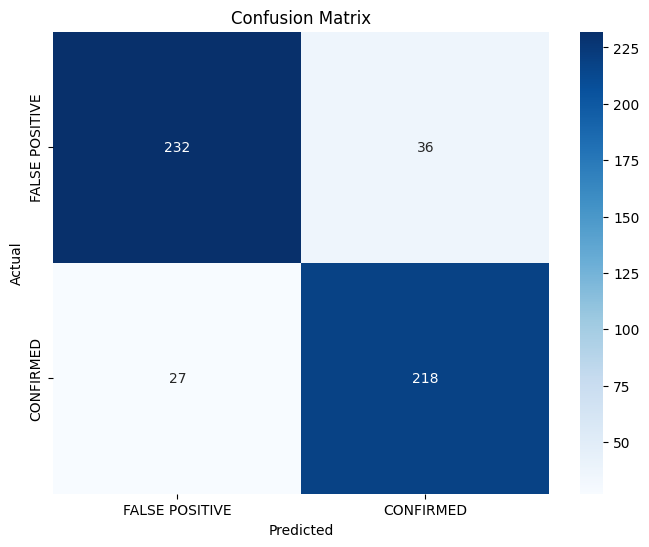

In [10]:
labels = ['FALSE POSITIVE', 'CONFIRMED']

Y_pred_probs = model.predict(X_test)
Y_pred = (Y_pred_probs >= 0.5).astype(int).flatten()
Y_true = Y_test.values.astype(int).flatten() 

Y_pred_strings = [labels[i] for i in Y_pred]
Y_true_strings = [labels[i] for i in Y_true]

cm = confusion_matrix(Y_true_strings, Y_pred_strings, labels=labels)
print(classification_report(Y_true_strings, Y_pred_strings, target_names=labels))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# TESS model inference

## Data preprocessing

In [11]:
filename = "tess_db.csv"
df = pd.read_csv(filename, comment='#')
cols_to_drop = [
    "rowid",'tfopwg_disp', "toi", "toipfx", "tid", "ctoi_alias", "pl_pnum",
    "rastr", "raerr1", "raerr2", "decstr", "dec", "decerr1", "decerr2",
    "st_pmralim", "st_pmrasymerr",
    "st_pmdeclim", "st_pmdecsymerr",
    "pl_tranmidlim", "pl_tranmidsymerr",
    "pl_orbperlim", "pl_orbpersymerr",
    "pl_trandurhlim", "pl_trandurhsymerr",
    "pl_trandeplim", "pl_trandepsymerr",
    "pl_radelim", "pl_radesymerr",
    "pl_insolerr1", "pl_insolerr2", "pl_insollim", "pl_insolsymerr",
    "pl_eqterr1", "pl_eqterr2", "pl_eqtlim", "pl_eqtsymerr",
    "st_tmaglim", "st_tmagsymerr",
    "st_distlim", "st_distsymerr",
    "st_tefflim", "st_teffsymerr",
    "st_logglim", "st_loggsymerr",
    "st_radlim", "st_radsymerr",
    "toi_created", "rowupdate"
]
df_clean = df.drop(columns=cols_to_drop).reset_index(drop=True)

Y = df['tfopwg_disp'].map({'FP': 0, 'FA': 0, 'CP': 1, 'KP': 1})
X = df.drop(columns=cols_to_drop)
X_filled = X.fillna(0)
X_encoded = pd.get_dummies(X_filled, drop_first=False).astype(np.float32)

mask = Y.isna()
X_encoded = X_encoded[mask]
scaler = joblib.load('tess_scaler.pkl')
X_scaled = scaler.transform(X_encoded).astype(np.float32)

## Predictions generation

In [12]:
labels = ['FALSE POSITIVE', 'CONFIRMED']
model = keras.models.load_model('tess.keras')
pred_org = model.predict(X_scaled)
pred = (pred_org >= 0.5).astype(int).flatten()

161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


## Saving predictions

In [13]:
candidates_meta = df.loc[mask, ['toi']]

with open('tess_predictions.csv', 'w') as f:
    f.write('toi,tfopwg_disp_pred,tfopwg_disp_pred_value\n')
    for i, (_, row) in enumerate(candidates_meta.iterrows()):
        f.write(f"{row['toi']},{labels[pred[i]]},{pred_org[i][0]}\n")

# TESS Exoplanet candidates catalog export to Celestia
This section of the notebook processes the **TESS mission exoplanet catalog** to generate `.stc`, `.ssc`, and `.cel` files compatible with **Celestia**.

## Function definitions

In [ ]:
G = 6.67430e-11
R_sun = 6.957e8
M_sun = 1.989e30
L_sun = 3.828e26
sigma = 5.670374419e-8

def estimate_semimajor_axis(row):
    try:
        if pd.isna(row.get("pl_orbper")) or pd.isna(row.get("st_rad")) or pd.isna(row.get("st_logg")):
            return np.nan
        R_star = row["st_rad"] * R_sun
        g_cgs = 10 ** row["st_logg"]
        g = g_cgs / 100.0
        M_star = g * R_star**2 / G
        P_sec = row["pl_orbper"] * 86400.0
        a_m = (G * M_star * P_sec**2 / (4 * np.pi**2))**(1/3)
        a_au = a_m / 1.496e11
        return a_au
    except Exception:
        return np.nan

def generate_star(star_id, star_name, ra, dec, distance_ly, appmag, spectral_type):
    entry = ''
    entry += f'{star_id} "{star_name}" {{\n'
    entry += f'    RA {ra:.6f}\n'
    entry += f'    Dec {dec:.6f}\n'
    entry += f'    Distance {distance_ly:.2f}\n'
    entry += f'    SpectralType "{spectral_type}"\n'
    entry += f'    AppMag {appmag:.2f}\n'
    entry += '}\n\n'
    return entry

textures = [
    'GJ_504_b.jpg','HAT-P-11_b.jpg','Kepler-452_b.jpg','Proxima_Cen_b.jpg',
    'HD_189733_b.jpg','Kepler-7_b.jpg','YZ_Cet_d.jpg','Kepler-22_b.jpg',
    'OGLE-2005-BLG-390L_b.jpg','exo-class1.*','exo-class2.*','exo-class3.*',
    'exo-class4.*','exo-class5.*','venuslike.*','asteroid.*'
]

def generate_planet(star_name, planet_name, radius_km, period, semimajoraxis, eccentricity, inclination, distance, confidence, temperature):
    entry = ''
    texture = rand.choice(textures)
    entry += f'"{planet_name}" "{star_name}"\n'
    entry += '{\n'
    entry += '    Class "Planet"\n'
    entry += f'    Radius {radius_km:.2f}\n'
    entry += f'    Texture "{texture}"\n'
    if not (pd.isna(period) and pd.isna(semimajoraxis)):
        entry += '    EllipticalOrbit\n'
        entry += '    {\n'
        if not pd.isna(period):
            entry += f'        Period {period:.6f}\n'
        if not pd.isna(semimajoraxis):
            entry += f'        SemiMajorAxis {semimajoraxis:.6f}\n'
        entry += f'        Eccentricity {0.0 if pd.isna(eccentricity) else eccentricity:.6f}\n'
        entry += f'        Inclination {0.0 if pd.isna(inclination) else inclination:.6f}\n'
        # entry += f'        Distance "Approx. {distance:.6f} light years away from Earth"\n'
        # entry += f'        Confidence {int(confidence*100)}%\n'
        # entry += f'        Temperature {temperature}\n'
        entry += '    }\n'
    entry += '}\n\n'
    return entry

def generate_script_entry(planet_name, star_name, distance_ly, pred, value):
    text = f'Planet: {planet_name}\nApprox. {round(distance_ly,2)} light years away from Earth\n'
    if str(pred).upper() == "CONFIRMED":
        text += "Prediction: Real exoplanet\n"
        text += f'Confidence: {int(value*100)}%'
    elif str(pred).upper() == "FALSE POSITIVE":
        text += 'Prediction: False positive\n'
        text += f'Confidence: {int((1-value)*100)}%'
    else:
        text += "Prediction: unknown\n"
    entry = ''
    entry += f'select {{object "{star_name}"}}\n'
    entry += f'select {{object "{planet_name}"}}\n'
    entry += 'goto { time 6 distance 5 }\n'
    entry += 'wait { duration 6 }\n'
    entry += f'print {{ text "{text}"\n'
    entry += '         origin "top"\n'
    entry += '         row 5\n'
    entry += '         column -8\n'
    entry += '         duration 6 }\n'
    entry += 'orbit {duration 6 rate 60 axis [0 1 0] }\n\n'
    return entry


## Folder structure declaration

In [15]:
tess_file = "tess_db.csv"
tess_predictions_file = "tess_predictions.csv"
local_extras = "extras"
os.makedirs(local_extras, exist_ok=True)
scripts_dir = os.path.join(local_extras, "Scripts")
os.makedirs(scripts_dir, exist_ok=True)

## Loading predictions from file

In [16]:
df_tess = pd.read_csv(tess_file, comment="#")
df_tess_candidates = df_tess[df_tess["tfopwg_disp"] == "PC"].copy()
df_tess_candidates["distance_ly"] = df_tess_candidates["st_dist"] * 3.26156

tess_predictions = pd.read_csv(tess_predictions_file)
tess_predictions = tess_predictions[tess_predictions["tfopwg_disp_pred"] == "CONFIRMED"].copy()
df_tess_candidates = df_tess_candidates.merge(
    tess_predictions[["toi", "tfopwg_disp_pred", "tfopwg_disp_pred_value"]],
    on="toi",
    how="inner"
)

## Generating host stars catalog

In [17]:
tess_stars_stc_path = os.path.join(local_extras, "toi_hosts.stc")
with open(tess_stars_stc_path, "w") as stc_file:
    for idx, row in df_tess_candidates.iterrows():
        if pd.isna(row.get("pl_rade")):
            continue
        entry = generate_star(
            star_id=rand.randint(100000,999999),
            star_name=f'Star-{row["toi"]}',
            ra=row["ra"],
            dec=row["dec"],
            distance_ly=row["distance_ly"],
            appmag=row["st_tmag"] if pd.notna(row.get("st_tmag")) else 12,
            spectral_type="G0"
        )
        stc_file.write(entry)

print(tess_stars_stc_path)


extras/toi_hosts.stc


## Generating candidate exoplanets catalog

In [18]:
tess_planets_ssc_path = os.path.join(local_extras, "toi_candidates.ssc")
with open(tess_planets_ssc_path, "w") as ssc_file:
    for idx, row in df_tess_candidates.iterrows():
        if pd.isna(row.get("pl_rade")):
            continue
        radius_km = row["pl_rade"] * 6378.0
        sma = estimate_semimajor_axis(row)
        entry = generate_planet(
            star_name=f'Star-{row["toi"]}',
            planet_name=f'TOI-{row["toi"]}',
            radius_km=radius_km,
            period=row.get("pl_orbper"),
            semimajoraxis=sma,
            eccentricity=0.0,
            inclination=0.0,
            distance=float(row['distance_ly']),
            confidence=row['tfopwg_disp_pred_value'],
            temperature=row['pl_eqt']
        )
        ssc_file.write(entry)

print(tess_planets_ssc_path)


extras/toi_candidates.ssc


## Generating TESS visualizer script

In [19]:
tess_cel_file_path = os.path.join(scripts_dir, "toi_candidates.cel")
with open(tess_cel_file_path, "w") as f_cel:
    f_cel.write("{\n")
    f_cel.write('select {object "Earth"}\n')
    f_cel.write('changedistance {duration 8 rate 4}\n')
    for idx, row in df_tess_candidates.iterrows():
        if pd.isna(row.get("pl_rade")):
            continue
        entry = generate_script_entry(
            planet_name=f'TOI-{row["toi"]}',
            star_name=f'Star-{row["toi"]}',
            distance_ly=row.get("distance_ly", 0),
            pred=row.get("tfopwg_disp_pred", "unknown"),
            value=float(row.get("tfopwg_disp_pred_value", 0.5)) if not pd.isna(row.get("tfopwg_disp_pred_value")) else 0.5
        )
        f_cel.write(entry)
    f_cel.write("}\n")

print(tess_cel_file_path)

extras/Scripts/toi_candidates.cel
